# Toxic Spans Detection

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DougTrajano/olid-br/blob/master/notebooks/baselines/toxic_spans_detection.ipynb)

In this notebook, we will train a model that detects toxic spans in toxic comments. The results can be used to highligh which parts of a given comment are toxic.

This task was first proposed in [SemEval 2021 Task 5: Toxic Spans Detection - CodaLab Competition](https://competitions.codalab.org/competitions/25623).

## Setup

In this section, we will set up the environment for the notebook.

If we are running this notebook on Google Colab, we will clone the repository and install the required packages.

We will also load the required environment variables from the `.env` file.

In [1]:
import sys

# Running on Google Colab
if "google.colab" in sys.modules:
    !git clone https://github.com/DougTrajano/olid-br.git
    !mv olid-br/* .
    !rm -rf olid-br
    !pip install -r requirements.txt
    env_file = "environment"
else:
    from pathlib import Path
    if str(Path(".").absolute().parent) not in sys.path:
        sys.path.append(str(Path(".").absolute().parent.parent))
    env_file = "../../.env"

from dotenv import load_dotenv

load_dotenv(env_file)

True

## Imports

In [2]:
import ast
import csv
import itertools
import os
import random
import string
import sys
import warnings

import numpy as np
import pandas as pd
from typing import List

import spacy
from spacy import displacy
from spacy.tokens import Doc
from spacy.training.example import Example
from sklearn.base import BaseEstimator
import tensorflow as tf
import matplotlib.pyplot as plt

SPECIAL_CHARACTERS = string.whitespace

In [3]:
from src.modeling.utils import download_dataset

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 30,
    "dropout_rate": 0.1,
    "use_cuda": True if tf.config.list_physical_devices("GPU") else False
}

# Set seeds for reproducibility
random.seed(params["seed"])
np.random.seed(params["seed"])
tf.random.set_seed(params["seed"])
spacy.util.fix_random_seed(params["seed"])

In [4]:
def f1_score(y_true: List[int], y_pred: List[int]):
    """
    Compute the F1 score, also known as balanced F-score or F-measure.
    (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714

    Args:
    - y_true: a list of offsets serving as the ground truth
    - y_pred: a list of predicted offsets

    Returns:
    - f1: the F1 score
    """
    if len(y_true) == 0:
        return 1. if len(y_pred) == 0 else 0.
    if len(y_pred) == 0:
        return 0.
    pred_set = set(y_pred)
    true_set = set(y_true)
    nom = 2 * len(pred_set.intersection(true_set))
    denom = len(pred_set) + len(true_set)
    return float(nom)/float(denom)

def _contiguous_ranges(span_list: List[int]):
    """Extracts continguous runs [1, 2, 3, 5, 6, 7] -> [(1,3), (5,7)].
    
    Args:
    - span_list: a list of span indicies

    Returns:
    - A list of tuples containing the start and end of each continguous run.
    """
    output = []
    for _, span in itertools.groupby(
        enumerate(span_list), lambda p: p[1] - p[0]):
        span = list(span)
        output.append((span[0][1], span[-1][1]))
    return output

def fix_spans(spans: List[int], text: str, special_characters: str = SPECIAL_CHARACTERS):
    """Applies minor edits to trim spans and remove singletons.
    
    Args:
    - spans: a list of span indicies
    - text: the text to which the spans apply
    - special_characters: a string containing special characters to remove from the text

    Returns:
    - A list of fixed spans.
    """
    cleaned = []
    for begin, end in _contiguous_ranges(spans):
        while text[begin] in special_characters and begin < end:
            begin += 1
        while text[end] in special_characters and begin < end:
            end -= 1
        if end - begin > 1:
            cleaned.extend(range(begin, end + 1))
    return cleaned

def spans_to_ents(doc: Doc, spans: List[int], label: str):
  """Converts span indicies into spacy entity labels.
  
  Args:
  - doc: a spacy Doc object
  - spans: a list of span indicies
  - label: the entity label to assign to the spans

  Returns:
  - A list containing start, end, and label.
  """
  started = False
  left, right, ents = 0, 0, []
  for x in doc:
    if x.pos_ == "SPACE":
      continue
    if spans.intersection(set(range(x.idx, x.idx + len(x.text)))):
      if not started:
        left, started = x.idx, True
      right = x.idx + len(x.text)
    elif started:
      ents.append((left, right, label))
      started = False
  if started:
    ents.append((left, right, label))
  return ents

In [5]:
class ToxicSpansDetection(BaseEstimator):
    def __init__(self, spacy_model: str = "pt_core_news_lg", toxic_label: str = "TOXIC"):
        """Initializes the model.

        Args:
        - spacy_model: the spaCy model to use.
        """
        self.nlp = spacy.load(spacy_model)
        self.toxic_label = toxic_label
        self._model = None
        self.losses = []
    
    def fit(self, X: List[str], y: List[int], epochs: int = 30, dropout_rate: float = 0.5):
        """Fits the model.

        Args:
        - X: the list of texts.
        - y: the list of labels.
        - epochs: the number of epochs to train the model.
        - dropout_rate: the dropout rate to use.
        """
        training_data = []
        for n, (text, spans) in enumerate(zip(X, y)):
            doc = self.nlp(text)
            ents = spans_to_ents(doc, set(spans), self.toxic_label)
            training_data.append((doc.text, {"entities": ents}))

        self._model = spacy.blank("pt")
        self._model.vocab.strings.add(self.toxic_label)
        ner = self.nlp.create_pipe("ner")
        self._model.add_pipe("ner", last=True)
        ner.add_label(self.toxic_label)

        pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
        unaffected_pipes = [
            pipe for pipe in self._model.pipe_names
            if pipe not in pipe_exceptions]
            
        with self._model.disable_pipes(*unaffected_pipes):
            self._model.begin_training()

            for epoch in range(epochs):
                random.shuffle(training_data)
                losses = {}
                batches = spacy.util.minibatch(
                    items=training_data,
                    size=spacy.util.compounding(
                        4.0, 64.0, 1.01))

            for batch in batches:
                examples = []
                for text, annotations in batch:
                    example = Example.from_dict(self.nlp.make_doc(text), annotations)
                    examples.append(example)
                self._model.update(examples, drop=dropout_rate, losses=losses)
                self.losses.append(losses["ner"])

    def _predict(self, X: str) -> List[int]: 
        """Predicts the toxic spans for a given text.

        Args:
        - X: the text.

        Returns:
        - the toxic spans as a list of integers.
        """
        predictions = []
        doc = self._model(X)
        for ent in doc.ents:
            predictions.extend(range(ent.start_char, ent.end_char))
        return predictions

    def predict(self, X: List[str] | str) -> List[int] | List[List[int]]:
        """Predicts the labels.
        
        Args:
        - X: the list of texts or a single text.

        Returns:
        - the toxic spans as a list of integers or a list of lists of integers.
        """
        if isinstance(X, (list, tuple, np.ndarray)):
            pred = []
            for x in X:
                pred.append(self._predict(x))
        elif isinstance(X, str):
            pred = self._predict(X)
        else:
            raise ValueError("X must be a list of strings or a single string.")
        return pred
        
    def score(self, X: List[str], y: List[int]):
        scores = []
        preds = []
        for text, spans in zip(X, y):
            pred = self.predict(text)
            preds.append(pred)
            score = f1_score(pred, spans)
            scores.append(score)
        return np.mean(scores)
        
    def save(self, path: str | Path):
        """Saves the model to a file.

        Args:
        - path: the path to the file.
        """
        self._model.to_disk(path)

    def plot_losses(self, xlabel: str = "Epoch", ylabel: str = "Loss"):
        plt.plot(self.losses)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

## Load data

In this section, we will download the data and load it into a pandas dataframe.

In [6]:
files = download_dataset(
    ["train.csv", "test.csv"]
)

train_data = files["train.csv"]
test_data = files["test.csv"]

print(f"Shape: {train_data.shape}")
train_data.head()

Shape: (6673, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


In [ ]:
print(f"Shape: {test_data.shape}")
test_data.head()

In [7]:
train_data = train_data[
    (train_data["toxic_spans"].notnull()) & \
        (train_data["toxic_spans"] != "[]")]

X_train = train_data["text"].values
y_train = [ast.literal_eval(y) for y in train_data["toxic_spans"].values]

test_data = test_data[
    (test_data["toxic_spans"].notnull()) & \
        (test_data["toxic_spans"] != "[]")]

X_test = test_data["text"].values
y_test = [ast.literal_eval(y) for y in test_data["toxic_spans"].values]

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Count: 5317


## Training model

Average F1: 0.1909


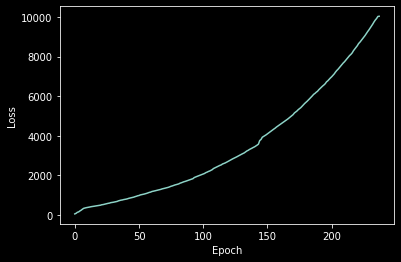

In [9]:
model = ToxicSpansDetection()

model.fit(
    X_train, y_train,
    epochs=params["num_train_epochs"],
    dropout_rate=params["dropout_rate"])

score = model.score(X_test, y_test)

print(f"Average F1: {score:.4f}")

model.plot_losses()

## Evaluation

In [10]:
score = model.score(X_test, y_test)

print(f"Average F1: {score:.4f}")

Average F1: 0.1909


## Test predictions

In [11]:
for i in range(10):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        displacy.render(model._model(X_test[i]), style="ent")